<div style="
    font-variant: small-caps;
    font-weight: bold;
    font-size: 30px;
    text-align: center;
    padding: 15px;
    margin: 10px;">Advanced Statistical Inference</div>
    <div style="
    font-variant: small-caps;
    font-weight: normal;
    font-size: 16px;
    text-align: center;
    padding: 15px;
    margin: 10px;">Analysis of MNIST & CIFAR10 with Naive Bayes, MLE and Bayesian inference.</div>
<div style="display: inline-block; font-family: 'Lato', sans-serif; font-size: 12px; font-weight: bold; line-height: 12px; letter-spacing: 1px; padding: 10px 15px 8px;">07/06/2017</div>
    
<div style="
    float:right;
    font-size: 12px;
    line-height: 12px;
    padding: 10px 15px 8px;">Alberto IBARRONDO & Jonas WACKER</div>

# Summary
This notebook implements from scratch (with no help of high level libraries) **Naive Bayes** and **Bayesian Linear Regression** and applies them all to classify the images from two well known datasets: MNIST and CIFAR10. Also, in the final section we implement a first set of **convolutional layers** to feed the linear regression and achieve a final accuracy of 97%.

# 1. Import Datasets

### 1.1 MNIST

In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from sklearn.metrics import confusion_matrix as cmx
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist_X_train, mnist_y_train = load_mnist(dataset='training')
mnist_X_test,  mnist_y_test  = load_mnist(dataset='testing')

In [3]:
def vectorize(X):
    return X.reshape((X.shape[0], np.prod(X.shape[1:])))

In [4]:
def dataSeparation(X, y, n_classes=10, arrToCol=True):
    # Convert to from square image to vector of values
    if(arrToCol): X = vectorize(X)
    # Separate data by classes    
    separatedData = [[] for i in range(n_classes)]
    for data, label in zip(X, y):
        separatedData[label].append(data)
    # Return data in a list of numpy arrays    
    return [np.array(data) for data in separatedData]

<div class="alert alert-info">
<h3>Comment</h3>
We implement **dataSeparation** to separate the data into a list of np arrays ordered by the label value. also, we implement the vectorization of the input in the function **vectorize**.
</div>

### 1.2 CIFAR 10

In [5]:
cfi, cfl= load_cifar10('cifar-10-python.tar.gz')

In [6]:
cifar_X_train = np.concatenate([
    cfi['data_batch_1'], cfi['data_batch_1'], cfi['data_batch_3'],
    cfi['data_batch_4'], cfi['data_batch_5']])
cifar_y_train = np.concatenate([
    cfl['data_batch_1'], cfl['data_batch_1'], cfl['data_batch_3'],
    cfl['data_batch_4'], cfl['data_batch_5']])
cifar_X_test = cfi['test_batch']
cifar_y_test = cfl['test_batch']

# 2. Descriptive Analytics

## 2.1 MNIST

### 2.1.1 Description of MNIST

In [7]:
# Descriptive analytics over MNIST
print('Length of Training Set: %d'%len(mnist_X_train))
print('Length of Test Set: %d'%len(mnist_X_test))
print('Image sizes: [%d x %d]'%(mnist_X_test.shape[1:]))

Length of Training Set: 60000
Length of Test Set: 10000
Image sizes: [28 x 28]


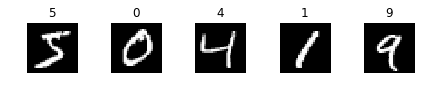

In [8]:
# Visualize MNIST examples
for i in range(5):
    image = mnist_X_train[i]
    plt.subplot(1, 5, i+1);           plt.axis('off')
    plt.title(mnist_y_train[i]);      plt.imshow(image, cmap='gray')
plt.tight_layout(); plt.show()

## 2.2 Distribution of labels in MNIST

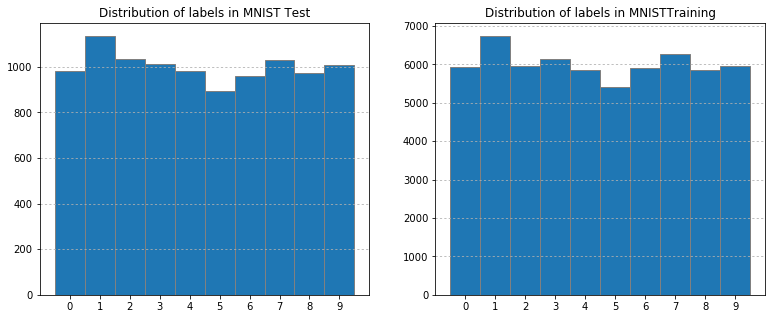

In [13]:
# Distribution of labels in MNIST
def plotLabelHist(y_test, y_train, title):
    fig, ax = plt.subplots(1,2,figsize=(13,5)); b=np.arange(0,11)-0.5
    h_t = ax[0].hist(y_test, edgecolor='gray', align='mid', bins=b )
    ax[0].set_xticks((np.arange(0,10))); ax[0].grid(axis='y', linestyle=':')
    ax[0].set_title("Distribution of labels in "+title+" Test")
    h_tr = ax[1].hist(y_train, edgecolor='gray', align='mid', bins=b )
    ax[1].set_xticks((np.arange(0,10))); ax[1].grid(axis='y', linestyle=':')
    ax[1].set_title("Distribution of labels in "+title+"Training")
    plt.show(); return h_t, h_tr
mnist_h_t, mnist_h_tr = plotLabelHist(mnist_y_test, mnist_y_train, "MNIST")

In [10]:
print("MNIST Test -> [Min: %d, Max: %d, Mean: %d]"%
      (min(mnist_h_t[0]), max(mnist_h_t[0]), np.mean(mnist_h_t[0])))
print("MNIST Training -> [Min: %d, Max: %d, Mean: %d]"%
      (min(mnist_h_tr[0]),max(mnist_h_tr[0]),np.mean(mnist_h_tr[0])))

MNIST Test -> [Min: 892, Max: 1135, Mean: 1000]
MNIST Training -> [Min: 5421, Max: 6742, Mean: 6000]


<div class="alert alert-info">
<h3>Comment</h3>
The mnist dataset comprises 50000 training images and 10000 test images, each representing a single digit that is already correctly labelled.
Each input image is represented by an array of 784 8-bit integers (values range from 0 - black to 255 white). This array can be reshaped such that it leads to a 28x28 b/w image.<br /><br />

The labels are fairly distributed in the test as well as the training set, with a difference of 1.3K between minimum and maximum in the latter.<br /><br />
This is a good thing because it means that we have more or less the same amount of training data for each digit and we can hope that the model will learn the recognition of each of them equally well. Having an even distribution of test labels is also a good thing because this will lead to comparable test results (precision/recall) among the labels.
</div>

## 2.2 CIFAR10

### 2.2.1 Description of CIFAR

In [11]:
# Sizes of CIFAR
print("Number of Training batches: 5")
print("Batch sizes: %d"% cifar_X_train.shape[0])
print("Image sizes: %d px with %d RGB colours each"%cifar_X_train.shape[1:])

Number of Training batches: 5
Batch sizes: 50000
Image sizes: 1024 px with 3 RGB colours each


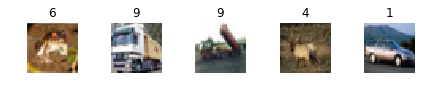

In [12]:
# Plot some example images
for i in range(5):
    image = cifar_X_train[i].reshape(32, 32, 3)
    plt.subplot(1, 5, i+1);     plt.axis('off')
    plt.title(cifar_y_train[i]);plt.imshow(image)
plt.tight_layout();             plt.show()

## 2.2 Distribution of labels in CIFAR

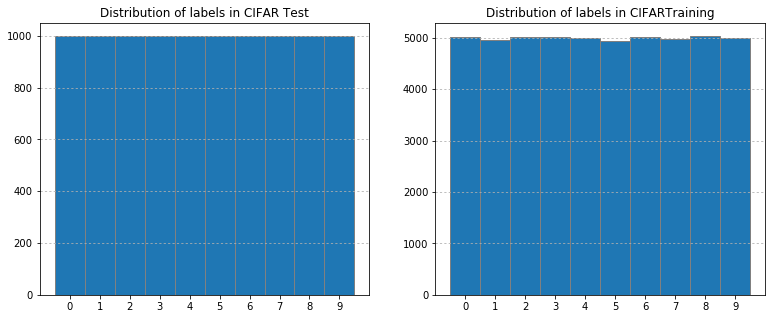

In [14]:
cifar_h_t, cifar_h_tr = plotLabelHist(cifar_y_test, cifar_y_train, "CIFAR")

In [191]:
print("CIFAR Test -> [Min: %d, Max: %d, Mean: %d]"%
      (min(cifar_h_t[0]), max(cifar_h_t[0]), np.mean(cifar_h_t[0])))
print("CIFAR Training -> [Min: %d, Max: %d, Mean: %d]"%
      (min(cifar_h_tr[0]), max(cifar_h_tr[0]), np.mean(cifar_h_tr[0])))

CIFAR Test -> [Min: 1000, Max: 1000, Mean: 1000]
CIFAR Training -> [Min: 4949, Max: 5038, Mean: 5000]


<div class="alert alert-info">
<h3>Comment</h3>
The CIFAR10 dataset comprises 50000 training images (divided in 5 batches) and 10000 test images, each representing an object in a coloured image that is already correctly labelled.
Each input image is represented by an array of 1024 RGB values (3x8-bit integers, values range from 0 - 255). This array reshapes to a 32x32 colour image.<br /><br />
Here again, the labels are almost evenly distributed in the training set. In the test set they are equally distributed. We will have the same amount of training data for each class and thus we will train each of them equally well. Having an even distribution of test labels is also a good thing because this will lead to comparable test results (precision/recall) among the labels.<br /><br />
The training batches are not split by different kinds of objects but are simply representative partitions of the entire training data. Therefore, it is possible to train models on a single batch of the entire dataset if computational resources are limited.
</div>

# 3. Classification

## 3.1 Naive Bayes Classifier - NBC
The Naivve Bayes Classifier implementation is divided into three functions:
- **Distributions**: calculates mean, variance and prior of the given data in order to build the features for the NBC model. The mean and variance are applied to each feature in the input data X, while the prior comes from the distribution of labels (although there are other ways to define the prior). *NBCDistributions should be run with X as training data*.
- **Predict**: using the dustributions from before, we predict the class of the data maximizing the likelihood, or in this case his logarithm to make it numericaly more stable. This is possible since f(x)=log(x) is a monotone function it serves as a biyective transformation of the likelihood. *NBCPredict should be run with X as test data*, based on mean and variance from the training data, and a prior that is freely chosen (the label distribution if you used NBCDistributions).
- **Evaluate**: calculates the accuracy of the predictions by matching it to the actual labels of the test data. This is a very generic function, and is used for evaluation of almost any classification algorithms. 

In [161]:
def NBCDistributions(X, y, prior=None, sep=True):
    if(sep): X_sep = dataSeparation(X, y)
    else:    X_sep = X
    mean = [np.mean(x, axis=0) for x in X_sep]
    variance = [np.var(x, axis=0) for x in X_sep]
    if(prior==None):
        prior = np.histogram(y)[0]/len(y)
    return mean, variance, prior

In [16]:
def NBCPredict (X, mean, variance, prior,
                pdf=st.multivariate_normal.logpdf):
    ProbArray = []
    for m, v, p in zip(mean, variance, prior):
        ProbArray.append(np.log(p) + pdf(X, m, v, True))
    return np.argmax(np.array(ProbArray), axis=0), \
           np.max(np.array(ProbArray), axis=0)

In [17]:
def NBCEvaluate(pred, y):
    accuracy = np.sum(pred == y) / len(y)
    return accuracy

## 3.2 Pros & Cons of NBC

<div class="alert alert-info">
<h3>Comment</h3>
The biggest **advantage** of the Naive Bayes Classifier is its **simplicity**. This leads to an easy-to-understand, quickly implemented algorithm that requires only some basic mathematical functions (could be implemented in almost any hardware nowadays). Its speed and ease of training is unmatched, easily trained even against small datasets, while being unsensitive to irrelevant features (avoids overfitting!). The simplicity is also perceived in the data-parameter ratio, because the naive bayes assumption lowers considerably the number of gaussian parameters fo be fit.  
<br/><br/>
On the other side, that same characteristic is its biggest **disadvantage**, due to the negative impact in accuracy caused by the **assumption of independency** between features (no cross correlation!). This is specially costly in our case since weare treating with images, that happen to have a very strong spatial correlation between its features.
</div>

## 3.3 Description of possible data preprocessing

<div class="alert alert-info">
<h3>Comment</h3>
The first process we suggest is to **balance** the training set in order to obtain a dataset evenly distributed amongst all different classes, which can be achieved either by filtering randomly some data from the more populated labels, obtaining a uniform probability distribution in the priors: 
$$p(x)=\frac{1}{nClasses}$$
<br/><br/>
Subsequently, we could **normalize** the data features by substracting the mean and dividing by the standard deviation. This proceduce may seem irrelevant (after all, we still would need to store the mean and variance in order to compute the same feature normalization on the test data), but it would help positively the numerical computation, because all the multivariate gaussians would have the same characteristics, allowing for its implementation in very low-end hardware (such as microcontrollers) using a table to hold the values of the normal distribution. In the case of CIFAR, it could be a good idea to convert the RGB images into B&W, since the RGB can lead to underfitting due to the vast amount of features (color can change gratly between images of the same class, cars don't always have the same color!)
<br/><br/>
Additionally, we could perform **outlier detection** and filtering. A simplistic approach would be to get rid of features spaced more than 1 or 2 standard deviations from the mean for that particular feature, but it could lead to overfiltering. The formal approach would involve using some clustering method such as K-Means and compute the outlier detection based on it.
<br/><br/>
There are some other posibilites for the data preprocessing, such as:
<ul>
<li>**Feature expansion**: since we know already that the images have a very strong spatial correlation, we could use convolutional filtering on it with a set of filters (either a standard set as used in image compression like in JPEG or a crafted set of filters obtained from the convolutional layers of a trained Convolutional Neural Network) and add those results as new features. There are other ways to expand the features, but the best ones should make up for the loss of spatial correlation (max/mean pooling could also help). </li>
<li>**Data reduction** using approaches such as Prinipal Component Analysis, which would help against the high number of dark pixels present in the images. However, since NBC is not very sensible to irrelevant features, we shouldn't expect much from this approach.</li>
</ul>
</div>

## 3.4 Applying NBC to both datasets
In order to monitor the optimization process, we decided to create a new function **NBCTrain** that will evaluate the performance on the test dataset while training the model. The evaluations will happen every *step* data samples used for training. Also, in order to visualize the results we have implemented **NBCPlotResults**. Anyway, the original optimization of Naive Bayes Classifier is achieved by using solely the functions defined in section 3.1. In the last part of this subsection we use those to test several data preprocessing procedures

In [95]:
def NBCTrain (X_train, y_train, X_test, y_test,
              prior=None, step=5000, flag_print=True):
    
    # INITIALIZE
    #  lists for figures of merit
    TrainAcc = []
    TestAcc = []
    TestMeanLogL = []
    #  number of epochs
    nEpochs = int(X_train.shape[0]/step)
    #  vectorization of input
    X_train = vectorize(X_train)
    X_test = vectorize(X_test)
    
    # TRAINING LOOP
    if(flag_print): print("Training a Naive Bayes Classifier")
    for i in range(1, nEpochs+1):
        
        # TRAIN: calculate the mean, variance and prior
        #  of the training dataset up to the ith batch
        m, v, prior = NBCDistributions(
            X_train[:(i*step)], y_train[:(i*step)],prior)
        
        # PREDICT classes and obtain log likelihood both
        #  for training (up to ith batch) and test dataset
        trainPred, _        = NBCPredict (X_train[:(i*step)],m, v, prior)
        testPred, TestLLike = NBCPredict (X_test, m, v, prior)
        
        # EVALUATE the accuracy on both datasets
        TrainAccuracy = NBCEvaluate(trainPred,  y_train[:(i*step)])
        TestAccuracy = NBCEvaluate(testPred, y_test)
        
        # SAVE results of the ith epoch
        TrainAcc.append(TrainAccuracy*100)
        TestAcc.append(TestAccuracy*100)
        TestMeanLogL.append(np.mean(TestLLike))
        
        # PRINT the results
        if(flag_print):
            print(" - Epoch %d:"        %(i*step),
                  "| TrainAcc = %.2f %%"%(TrainAcc[-1]),
                  "| TestAcc = %.2f %%" %(TestAcc[-1]),
                  "| TestLogLike = %.1f"%(TestMeanLogL[-1]))
        
    return TrainAcc, TestAcc, TestMeanLogL, testPred

In [254]:
def NBCPlotResults (TrainAcc, TestAcc, TestMeanLogL, title):
    fig, ax = plt.subplots(figsize=[7, 5])
    ax.plot(TrainAcc, label='Train Accuracy')
    ax.plot(TestAcc, label='Test Accuracy')
    ax2 = ax.twinx()
    ax2.plot(TestMeanLogL, ':', label='Test Log likelihood')
    fig.tight_layout()
    ax.set_title('Results of '+ title + 'training with NBC', fontsize=14)
    ax.set_xlabel('epoch(x1000)', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_ylabel('TestLogLikelihood', fontsize=12)
    ax.legend(loc=9, fontsize=11)
    ax2.legend(fontsize=11)
    plt.show()

### 3.4.1 NBC training with MNIST
First we train the model using **NBCDistributions**, **NBCPredict** and **NBCEvaluate** functions. After that, we run the training with **NBCTrain** and plot the results with **NBCPlotResults**.

In [109]:
# Model training without tracking performance
m, v, p =             NBCDistributions(mnist_X_train, mnist_y_train)
mnist_yPred_test, _ = NBCPredict (vectorize(mnist_X_test), m, v, p)
mnist_TestAccuracy =  NBCEvaluate(mnist_yPred_test, mnist_y_test)
print("Test Accuracy on MNIST for NBC: %.2f %%"%(mnist_TestAccuracy*100))

Test Accuracy on MNIST for NBC: 64.83 %


In [84]:
# Complete MNIST dataset used to train NBC tracking performance
mnist_TrainAcc, mnist_TestAcc, mnist_TestLogLikelihood,_ = \
    NBCTrain(mnist_X_train, mnist_y_train, mnist_X_test, mnist_y_test)

Training a Naive Bayes Classifier
 - Epoch 5000: | TrainAcc = 68.12 % | TestAcc = 64.68 % | TestLogLike = -2487.6
 - Epoch 10000: | TrainAcc = 68.07 % | TestAcc = 66.18 % | TestLogLike = -2517.9
 - Epoch 15000: | TrainAcc = 67.64 % | TestAcc = 66.84 % | TestLogLike = -2556.5
 - Epoch 20000: | TrainAcc = 67.27 % | TestAcc = 67.18 % | TestLogLike = -2567.6
 - Epoch 25000: | TrainAcc = 66.24 % | TestAcc = 66.01 % | TestLogLike = -2574.9
 - Epoch 30000: | TrainAcc = 65.67 % | TestAcc = 65.61 % | TestLogLike = -2581.8
 - Epoch 35000: | TrainAcc = 65.18 % | TestAcc = 65.05 % | TestLogLike = -2589.4
 - Epoch 40000: | TrainAcc = 64.57 % | TestAcc = 64.55 % | TestLogLike = -2593.7
 - Epoch 45000: | TrainAcc = 64.78 % | TestAcc = 64.79 % | TestLogLike = -2598.3
 - Epoch 50000: | TrainAcc = 64.92 % | TestAcc = 65.08 % | TestLogLike = -2606.4
 - Epoch 55000: | TrainAcc = 64.98 % | TestAcc = 64.97 % | TestLogLike = -2607.1
 - Epoch 60000: | TrainAcc = 64.99 % | TestAcc = 64.83 % | TestLogLike = -26

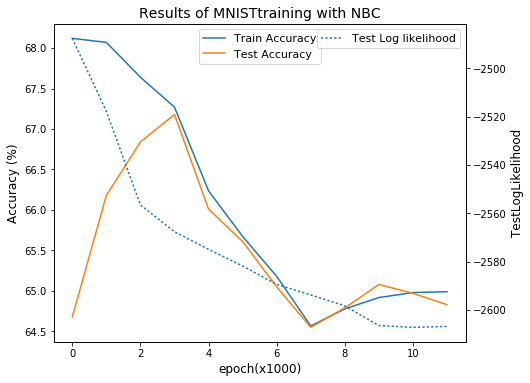

In [255]:
NBCPlotResults(mnist_TrainAcc, mnist_TestAcc, mnist_TestLogLikelihood, 'MNIST')

### 3.4.2 NBC training with CIFAR10

In [110]:
# Model training without tracking performance
m, v, p =             NBCDistributions(cifar_X_train, cifar_y_train)
cifar_yPred_test, _ = NBCPredict (vectorize(cifar_X_test), m, v, p)
cifar_TestAccuracy =  NBCEvaluate(cifar_yPred_test, cifar_y_test)
print("Test Accuracy on CIFAR for NBC: %.2f %%"%(cifar_TestAccuracy*100))

Test Accuracy on CIFAR for NBC: 29.54 %


In [88]:
cifar_TrainAcc, cifar_TestAcc, cifar_TestLogLikelihood = \
    NBCTrain(cifar_X_train, cifar_y_train, cifar_X_test, cifar_y_test)

Training a Naive Bayes Classifier
 - Epoch 5000: | TrainAcc = 30.32 % | TestAcc = 29.52 % | TestLogLike = -16700.7
 - Epoch 10000: | TrainAcc = 29.12 % | TestAcc = 29.31 % | TestLogLike = -16703.9
 - Epoch 15000: | TrainAcc = 29.27 % | TestAcc = 29.46 % | TestLogLike = -16702.7
 - Epoch 20000: | TrainAcc = 29.12 % | TestAcc = 29.31 % | TestLogLike = -16703.9
 - Epoch 25000: | TrainAcc = 29.14 % | TestAcc = 29.35 % | TestLogLike = -16701.8
 - Epoch 30000: | TrainAcc = 29.03 % | TestAcc = 29.50 % | TestLogLike = -16704.4
 - Epoch 35000: | TrainAcc = 28.79 % | TestAcc = 29.53 % | TestLogLike = -16708.5
 - Epoch 40000: | TrainAcc = 28.75 % | TestAcc = 29.57 % | TestLogLike = -16710.1
 - Epoch 45000: | TrainAcc = 28.59 % | TestAcc = 29.52 % | TestLogLike = -16710.2
 - Epoch 50000: | TrainAcc = 28.63 % | TestAcc = 29.54 % | TestLogLike = -16709.3


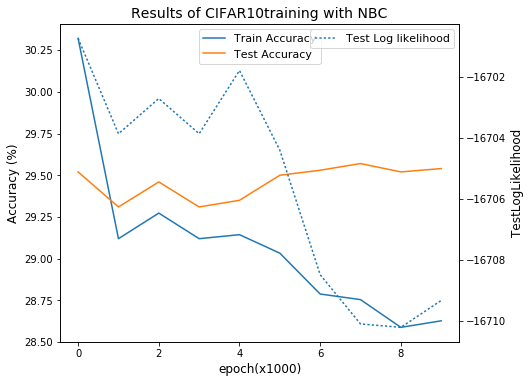

In [256]:
NBCPlotResults(cifar_TrainAcc, cifar_TestAcc, cifar_TestLogLikelihood, 'CIFAR10')

### 3.4.3 Implementing data preprocessing to improve accuracy

In [15]:
def dataBalancing(X, y):
    X_sep = dataSeparation(X, y)
    n_min = min(np.histogram(y)[0])
    X_balanced = [k[:n_min] for k in X_sep]
    return X_balanced

In [159]:
x_sep = dataSeparation(mnist_X_train, mnist_y_train)
x_bal = dataBalancing(mnist_X_train, mnist_y_train)

Old distribution: [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
Balanced distribution: [5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421]


In [163]:
# Model training with data balancing
m, v, p =    NBCDistributions(x_bal, 0, prior=np.ones(10)/10, sep=False)
mnistBal_yPred_test, _ = NBCPredict (vectorize(mnist_X_test), m, v, p)
mnistBal_TestAcc =  NBCEvaluate(mnistBal_yPred_test, mnist_y_test)
print("TestAcc on balanced MNIST for NBC: %.2f %%"%(mnistBal_TestAcc*100))

Test Accuracy on balanced MNIST for NBC: 65.10 %


In [171]:
def RGBtoGrayscale(X):
    return np.dot(X[...,:3], [0.299, 0.587, 0.114])

In [187]:
cifarGS_X_train = RGBtoGrayscale(cifar_X_train)
cifarGS_X_test = RGBtoGrayscale(cifar_X_test)
print("Old shape of CIFAR:", cifar_X_train.shape)
print("Grayscale shape of CIFAR", cifarGS_X_train.shape)

Old shape of CIFAR: (50000, 1024, 3)
Grayscale shape of CIFAR (50000, 1024)


In [183]:
# Model training without tracking performance
m, v, p =             NBCDistributions(cifarGS_X_train, cifar_y_train)
cifarGS_yPred_test, _ = NBCPredict (vectorize(cifarGS_X_test), m, v, p)
cifarGS_TestAcc =  NBCEvaluate(cifarGS_yPred_test, cifar_y_test)
print("TestAcc on CIFAR grayscale for NBC: %.2f %%"%(cifarGS_TestAcc*100))

Test Accuracy on CIFAR for NBC: 26.49 %


<div class="alert alert-info">
<h3>COMMENT</h3>
The accuracy has improved so little  with the data balancing that we shouldn't even consider it. The conversion from RGB to grayscale for CIFAR10 even worsens the results. As a general rule we can state that simplifying the data is not improving the model's performance.
</div>

## 3.5 Confusion Matrices for NBC

In [239]:
def plot_confusion_matrix(y, y_pred, title, classes=range(10)):
    cm = cmx(y, y_pred);      plt.figure(figsize=(7,5))
    plt.imshow(cm, cmap=plt.cm.Purples)
    plt.title(title);         plt.colorbar()
    plt.xticks(classes);      plt.yticks(classes)
    # Print Values in each box
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, math.ceil(cm[i, j]*100000)/100000,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > (2.*cm.max() / 3.) else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout(); 
    plt.show()

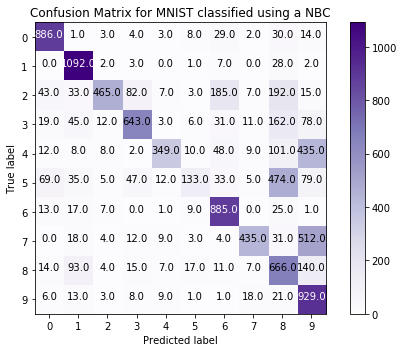

In [240]:
plot_confusion_matrix(mnist_y_test, mnist_yPred_test,
    'Confusion Matrix for MNIST classified using a NBC', classes=range(10))

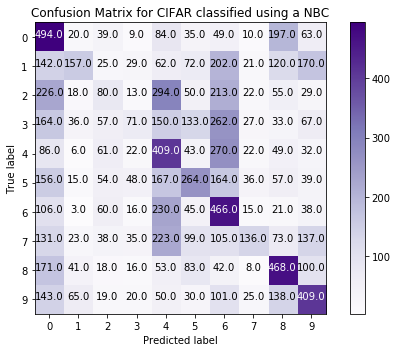

In [241]:
plot_confusion_matrix(cifar_y_test, cifar_yPred_test,
    'Confusion Matrix for CIFAR classified using a NBC', classes=range(10))

## 3.6 Analysis of Results

<div class="alert alert-info">
<h3>Comment</h3>
The accuracy on the classification using NBC is 64.83% for MNIST and 29.54% for the CIFAR. The performance is not very high when compared to other more modern approaches such as Neural Networks (that achieve accuracies above 90%). Nevertheless, since a random classifier outputting random class labels would be expected to achieve a 10% accuracy (on a balanced set), we can state that both models have extracted information from the dataset and applied it to classify. Also, note that there is almost no improvement in accuracy when using a bigger dataset (check figures of accuracy during training)
<br/><br/>
There is a major difference in performances between both datasets, probably caused by the increased complexity of the CIFAR10 dataset (real low resolution images vs simple handwritten images). For the MNIST, by analyzing the confusion matrix we detect errors concentrated in 4s and 7s misclassified as 9s, and 5s misclassified as 8s, with the diagonal reflecting an acceptable accuracy on predicting the right class. The confussion matrix for CIFAR10 is much more variate, as expected when we obtained sucha low accuracy.
<br/><br/>
Clearly the best ways to improve performance would be to expand the features in order to include information from the spatial correlation of the images, which could come from a convolutional layer using filters, or in a simpler fashion from a mean pool layer in which we would obtain the mean values of 2x2 and 3x3 (or other shapes) pixels and include them as new features. Another approach would be to use more complex models that included cross correlation of the input features during training, thus learning from the spatial distribution.
</div>

# 4. Linear Regression

## 4.1 Implementation of Bayesian Linear Regression

In [21]:
def preprocess_inputs(features, noise=0):
    '''Converts the input features into a format that is regressable.'''
    
    # convert training data to feature vectors
    reg_feat = np.array([f.flatten() for f in features], dtype='float')
    # add gaussian noise to make (X'X) invertible
    # otherwise problematic because images can be very sparse
    reg_feat += np.random.randn(len(features), len(reg_feat[0])) * noise
    # augment the feature matrix with bias terms
    reg_feat = np.hstack((np.array([np.ones(len(features))]).T, reg_feat))
    
    return reg_feat

In [194]:
def preprocess_labels(labels):
    '''Converts labels into one-hot vectors (target labels are categorical)'''
    enc = OneHotEncoder()
    converted_labels = np.array(labels).reshape(-1, 1)
    oh_labels = enc.fit_transform(converted_labels).toarray()
    
    return oh_labels

In [16]:
def obtain_mle_estimates(X, y):
    '''MLE-estimates for the regression weights and for the noise variance'''
    # W_hat is a matrix (num_features X num_distinct_labels)
    W_hat = np.linalg.inv(np.dot(X.T, X)).dot(X.T).dot(labels)
    # We now have an estimate for the noise variance for each target label
    ss_hat = 1/len(X) * np.linalg.norm(labels - np.dot(X, W_hat), axis=0)**2
    
    return W_hat, ss_hat

In [196]:
def obtain_bayesian_posterior(features, labels, ss):
    '''Returns the parameters (mu, sigma) for the posterior distribution of W'''
    dim_labels = labels.shape[1]
    D = features.shape[1]
    X_t_X = np.dot(features.T, features)
    ### define a prior on W:
    # We set the prior for each w vector to be standard normally distributed.
    # The impact of the prior will diminish the more training data we have.
    # Since we have 60000 samples, setting the prior arbitrarily is fine.
    # mu_0 becomes a matrix (one weight vector for each target label)
    mu_0 = np.zeros((D, dim_labels))
    sigma_0_ind = np.eye(D)
    sigma_0 = np.repeat(sigma_0_ind[:, :, np.newaxis], dim_labels, axis=2)
    ### compute the posterior for W:
    sigma_w = np.ndarray(sigma_0.shape)
    for idx in range(dim_labels):
        sigma_w[:,:,idx] = np.linalg.inv(1/ss[idx] *
                         X_t_X + np.linalg.inv(sigma_0[:,:,idx]))
    mu_w = np.ndarray(mu_0.shape)
    for idx in range(dim_labels):
        mu_w[:, idx] = sigma_w[:,:,idx] \
            .dot(1/ss[idx] * features.T.dot(labels[:, idx]) \
            + np.linalg.inv(sigma_0[:,:,idx]).dot(mu_0[:, idx]))
            
    return mu_w, sigma_w

## 4.2 Applying Bayesian Linear Regression to both datasets

### 4.2.1 Data Preprocessing

In [22]:
# convert training data to feature vectors
mnist_Xreg = preprocess_inputs(mnist_X_train, noise=0.01)
cifar_Xreg = preprocess_inputs(cifar_X_train)
mnist_ypre_train = preprocess_labels(mnist_y_train)
cifar_ypre_train = preprocess_labels(cifar_y_train)

In [198]:
# convert test data to feature vectors (no noise needed here, no inversion)
mnist_Xreg_test = preprocess_inputs(mnist_X_test)
cifar_Xreg_test = preprocess_inputs(cifar_X_test)

In [23]:
print("Shape MNIST: ", reg_X_mnist.shape, " | shape CIFAR", reg_X_cifar.shape)

Shape MNIST:  (60000, 785)  | shape CIFAR (50000, 3073)


### 4.2.2 Compute MLEs in order to get estimate for noise variance

In [ ]:
W_hat_mnist, ss_hat_mnist = obtain_mle_estimates(mnist_Xreg, mnist_ypre_train)
W_hat_cifar, ss_hat_cifar = obtain_mle_estimates(cifar_Xreg, cifar_ypre_train)

In [222]:
p_mnist = np.argmax(np.dot(mnist_Xreg_test, W_hat_mnist), axis=1)
p_cifar = np.argmax(np.dot(cifar_Xreg_test, W_hat_cifar), axis=1)

In [223]:
MLEeval = NBCEvaluate
print('MNIST TestAcc [MLE]: %.2f %%'%(100*MLEeval(p_mnist, mnist_y_test)))
print('CIFAR TestAcc using MLE: %.2f %%'%(100*MLEeval(p_cifar, cifar_y_test)))

MNIST TestAcc [MLE]: 86.05 %
CIFAR TestAcc using MLE: 35.74 %


### 4.2.3 Compute the posterior parameters

In [224]:
mu_w_mnist, sigma_w_mnist = obtain_bayesian_posterior(
    mnist_Xreg, mnist_ypre_train, ss_hat_mnist)
mu_w_cifar, sigma_w_cifar = obtain_bayesian_posterior(
    cifar_Xreg, cifar_ypre_train, ss_hat_cifar)

## 4.3 Visualizing prediction VS true target & MSE

In [ ]:
expected_num_mnist = np.argmax(np.dot(mnist_Xreg_test, mu_w_mnist), axis=1)
expected_num_cifar = np.argmax(np.dot(cifar_Xreg_test, mu_w_cifar), axis=1)

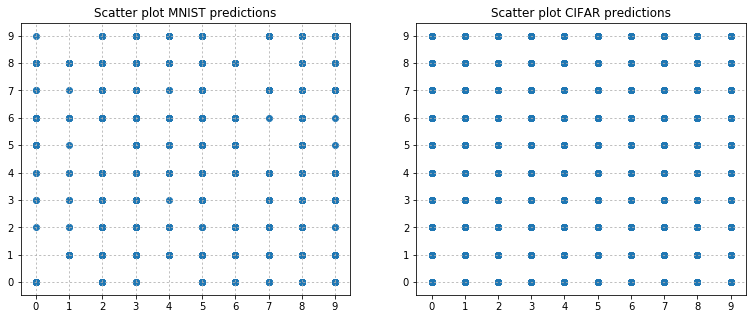

In [227]:
# Distribution of labels in MNIST
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].scatter(mnist_y_test, expected_num_mnist)
ax[0].set_xticks((np.arange(0,10))); ax[0].set_yticks((np.arange(0,10)))
ax[0].grid(axis='x', linestyle=':'); ax[0].grid(axis='y', linestyle=':')
ax[0].set_title("Scatter plot MNIST predictions")

ax[1].scatter(cifar_y_test, expected_num_cifar)
ax[1].set_xticks((np.arange(0,10))); ax[1].set_yticks((np.arange(0,10)))
ax[0].grid(axis='x', linestyle=':'); ax[1].grid(axis='y', linestyle=':')
ax[1].set_title("Scatter plot CIFAR predictions")
plt.show()

Computing the MSE (Mean Squared Error)

In [230]:
def MSE(y, y_expected): return 1 / len(y) * np.linalg.norm(y - y_expected)**2
MSE_mnist = MSE(mnist_y_test, expected_num_mnist)
MSE_cifar = MSE(cifar_y_test, expected_num_cifar)
print("MSE MNIST: ", MSE_mnist, " | MSE CIFAR: ", MSE_cifar)

MSE MNIST:  2.4319  | MSE CIFAR:  12.7056


<div class="alert alert-info">
<h3>Comment</h3>
We can see that our predictions cover a wide range (for CIFAR any kind of confusion is possible, for MNIST there are some gaps). We will observe the exact accuracies and prediction confusions in the next step. The MSE value tells us that on average we are sqrt(2.4) away from the true label for MNIST and sqrt(12.7) for CIFAR. Therefore, we already know that the regression model worked much better on MNIST than on CIFAR.
</div>

## 4.4 Discretization, Confusion Matrix & Performance

Discretizing the predictions was quite simple in our case. Since we use one-hot encoded labels, we simply take the "argmax" of our predictions to obtain a discrete prediction label. If we had run the regression against the original labels, the discretization step could be more complex because then we would have had to quantize the predicted labels in some way (e.g. round them).

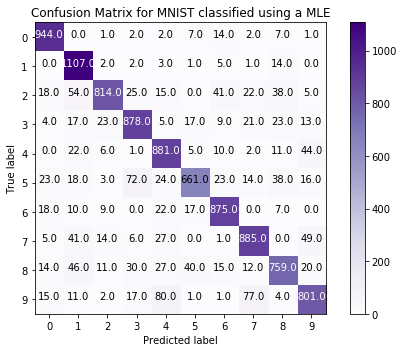

In [242]:
plot_confusion_matrix(mnist_y_test, expected_values_num_mnist,
      'Confusion Matrix for MNIST classified using a MLE', classes=range(10))

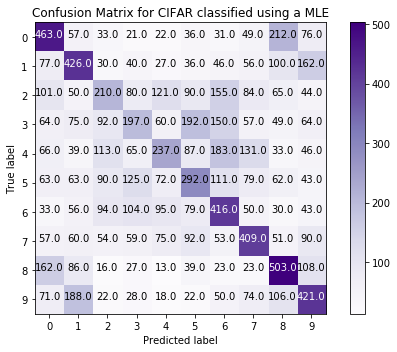

In [243]:
plot_confusion_matrix(cifar_y_test, expected_values_num_cifar,
      'Confusion Matrix for CIFAR classified using a MLE', classes=range(10))

In [24]:
print('Acc MNIST: %.2f %%'%(100* MLEeval(expected_num_mnist,mnist_y_test)))
print('Acc CIFAR: %.2f %%'%(100* MLEeval(expected_num_cifar,cifar_y_test)))

Acc MNIST: 86.05 %
Acc CIFAR: 35.74 %


<div class="alert alert-info">
<h3>Comment</h3>
<p>We achieve an accuracy of around 86% on MNIST meaning that 86% of our predictions are correct with the regression model that we implemented. A random guess would achieve 10% accuracy. For CIFAR we only achieve 36%.</p>

<p>MLE and the Bayesian approach lead to the same result meaning that for a large number of samples the expected prediction is equal to the MLE prediction. This is logical since the posterior distribution for W becomes more and more certain the more training samples we have (the variances for the W values decrease). Taking expected values gets closer to the actual value which also happens with the MLE estimator when adding more data.</p>
</div>

## 4.5 Regression VS Classification performance

<div class="alert alert-info">
<h3>Comment</h3>
Applying regression to classification tasks seems to work quite well (at least on MNIST) given that we apply the right preprocessing to the data (one-hot encoding of the training labels in our case). If we do not apply this preprocessing the results get a lot worse. Running a regression directly against categorical labels implies that we assume a linear relationship between the spatial values of the images and the categorical labels. However, this leads to a lot of confusions. <p>Example:</p>
<p>- The number 9 pushes weights of the pixels along its contours up, so that filled pixels along them increase the linear output towards the value of 9.</p>
<p>- At the same time the number 2 may share a lot of overlapping pixels with number 9 (depending on the handwritten digit we look at of course), which would push the weights in the opposite direction for those pixels.</p>
<p>- Therefore, it is hard to come up with a good set of weights that produces the desired output.</p>

<p>Assuming however, that we carry out the correct preprocessing of the training data, we see that regression algorithms can sometimes compete with classification algorithms. The performance is similar to the one of naive Bayes in the MNIST case.</p>
<p>For the CIFAR dataset things have not worked out so well. The regression worked to some extend (36% accuracy is definitely better than a random guess 10%) but there is still a lot of space for improvement.</p>
</div>

## 4.6 Limitation of using regression for classification

<div class="alert alert-info">
<h3>Comment</h3>
One limitation of the linear regression is the linear relationship that we assume between the input and the target labels. We have to assign a fixed weight to each pixel (plus an additional bias term). We could think of more flexible models like neural networks that only take certain combinations of pixels into account if they exceed a threshold value. These can even be extended to convolutional neural networks that take patterns inside images into account. Here the linear regression is clearly inferior because it does not produce translation or scale-invariant results. Shrinking the digit on an MNIST picture would make the trained regression model useless. Moreover, the linear regression does not take any care of structure in the data (which is important for image analysis). Shuffling the pixels and retraining the models would simply result in shuffled weights. For CIFAR we clearly need to incorporate the structure of the images into our model. Convolutional neural networks are known to work quite well.
</div>

# 5. Towards high Performance. Convolutional Layers

Our approach in order to achieve a considerably high performance in or models is to apply linear regression on the convolutional output of LeNet5. In order to train this CNN we use the keras Python library which makes it very easy to train neural networks and alter the architecture afterwards.
<p>As a first step we define the network architecture.</p>

## 5.1 LeNet5 with Keras

In [4]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
K.set_image_dim_ordering('th')
 
class LeNet:
    @staticmethod
    def build(width, height, depth, classes, weightsPath=None):
        # initialize the model
        model = Sequential()
        # first set of CONV => RELU => POOL
        model.add(Conv2D(6, (5, 5), padding="same",
                         input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # second set of CONV => RELU => POOL
        model.add(Conv2D(16, (5, 5), padding="valid"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(120)); model.add(Activation("relu"))
        # second set of FC => RELU layers
        model.add(Dense(84));  model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes));  model.add(Activation("softmax"))

        # if a weights path is supplied (inicating that the model was
        # pre-trained), then load the weights
        if weightsPath is not None:
            model.load_weights(weightsPath)

        # return the constructed network architecture
        return model

Using TensorFlow backend.


We then preprocess the MNIST input to make it compatible with the neural network.

In [5]:
training_features = np.array([feature / 255.0 for feature in mnist_X_train])
training_features = training_features[:, np.newaxis, :, :]
test_features = np.array([feature / 255.0 for feature in mnist_X_test])
test_features = test_features[:, np.newaxis, :, :]
training_labels = preprocess_labels(mnist_y_train)
test_labels = preprocess_labels(mnist_y_test)

In the next step we train the model...

In [68]:
from keras.optimizers import SGD
from keras.optimizers import Adam

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=0.01)
weights_path = 'lenet_weights'
model = LeNet.build(width=28, height=28, depth=1,
                    classes=10, weightsPath=weights_path)
model.compile(loss="categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])
 
# only train and evaluate the model if we *are not* loading a
# pre-existing model
if weights_path == None:
    print("[INFO] training...")
    model.fit(training_features, training_labels, batch_size=128, epochs=20,
        verbose=1)
 
    # show the accuracy on the testing set
    print("[INFO] evaluating...")
    (loss, accuracy) = model.evaluate(test_features, test_labels,
        batch_size=128, verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))
    
    model.save_weights('lenet_weights', overwrite=True)
    
print("[INFO] loaded model.")

[INFO] compiling model...
[INFO] loaded model.


and evaluate...

In [17]:
probs = model.predict(test_features)
predictions = probs.argmax(axis=1)
print(np.sum(predictions == mnist_y_test) / len(mnist_y_test))

0.9847


<div class="alert alert-info">
<h3>Comment</h3>
Using the LeNet 5 architecture, we achieve 98.47% accuracy after only 20 epochs
</div>

## 5.2 Modifying LeNet5 model

Our approach is to use the trained LeNet5 model and to remove the dense layers in order to keep only the output of the convolutional layers. This way we can obtain the output of the convolutions for each training and test feature with a set of pretrained convolutional filters. The output of the filters contains structural information about the image that will automatically be used by our regression model that we apply on top of this output.

In [69]:
# popping 6 layers -> output of the flatten layer after the convolutions
model.layers.pop(); model.layers.pop(); model.layers.pop()
model.layers.pop(); model.layers.pop(); model.layers.pop()
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []
model.compile(loss="categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])

In [70]:
mnist_Xconv_train = model.predict(mnist_X_train)
mnist_Xconv_test = model.predict(mnist_X_test)

## 5.3 Linear Regression on the convolutional output features

In [71]:
mnist_Xconv = preprocess_inputs(mnist_Xconv_train, noise=0.01)
mnist_Xconv_test = preprocess_inputs(mnist_Xconv_test, noise=0.01)

In [72]:
w_hat, ss_hat = obtain_mle_estimates(mnist_Xconv, mnist_y_train)
mu_w, sigma_w = obtain_bayesian_posterior(mnist_Xconv, mnist_y_train, ss_hat)

In [26]:
predictions = np.argmax(np.dot(mnist_Xconv_test, mu_w), axis=1)
print('Accuracy CNN-regression: %.2f %%'%MLEeval(predictions, mnist_y_test))

Accuracy CNN-regression: 97.26 %


<div class="alert alert-info">
<h3>Comment</h3>
Preprocessing the images with convolutional filters highers our regression model accuracy substantially. We now achieve 97.26% which is almost as good as LeNet5.
</div>